In [1]:
%%capture
!pip install darts

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import darts
import pandas as pd

from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

from darts import TimeSeries


zf = ZipFile("/content/drive/MyDrive/PRSA2017_Data_20130301-20170228.zip")

df = pd.DataFrame()
for file in zf.infolist():
    if file.filename.endswith('.csv'):
        df = df._append(pd.read_csv(zf.open(file)))

df['timestamp'] = pd.to_datetime(df[["year", "month", "day", "hour"]])
df.drop(columns=['No'], inplace=True)
df.sort_values(by=['timestamp', 'station']).head(10)

df = df.replace(df['station'].unique(), list(range(len(df['station'].unique()))))
df = df.replace(df['wd'].unique(), list(range(len(df['wd'].unique()))))

ts_df = df.dropna(subset = ['PM2.5'])

ts_df = ts_df[['PM2.5', 'timestamp', 'station', 'wd', 'WSPM', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'O3', 'CO', 'NO2', 'SO2']]
ts_df = ts_df.dropna(subset=ts_df.columns.values)


d = ts_df.timestamp - pd.to_datetime('2013-03-01 00:00:00')

delta_index = []
for delta in d:
    delta_index.append(int(delta.total_seconds()/3600))

ts_df['ts_ind'] = delta_index

target_series = TimeSeries.from_group_dataframe(ts_df[["PM2.5", 'ts_ind', 'station']], group_cols=['station'], time_col='ts_ind')
cov_series = TimeSeries.from_group_dataframe(ts_df.drop(["PM2.5",'timestamp'], axis=1), group_cols=['station'], time_col='ts_ind')

split_point = int(len(cov_series[0]) * 0.8)
split_point_2 = int(len(cov_series[0]) * 0.95)


past_target_series = []
future_target_series = []
test_target_series = []

series_for_mini_test = []
mini_test_target = []

for ts in target_series:
    past_target_series.append(ts.slice(0, split_point))
    future_target_series.append(ts.slice(split_point, split_point_2))
    test_target_series.append(ts.slice(split_point_2, len(ts)))
    series_for_mini_test.append(ts.slice(0, split_point_2))
    mini_test_target.append(ts.slice(split_point_2, split_point_2 + 12))

past_cov_series = []
future_cov_series = []
test_cov_series = []

mini_test_cov = []

for ts in cov_series:
    past_cov_series.append(ts.slice(0, split_point))
    future_cov_series.append(ts.slice(0, split_point_2))
    test_cov_series.append(ts.slice(split_point_2, len(ts)))
    mini_test_cov.append(ts.slice(split_point_2, split_point_2 + 12))

In [4]:
from darts.models import TFTModel

tftmodel = TFTModel.load("/content/drive/MyDrive/tft_model/11_11")

In [15]:
%%capture
from darts.metrics.metrics import rmse, mape

backtest_output = tftmodel.backtest(series = test_target_series,
                                      past_covariates=cov_series,
                                      future_covariates=test_cov_series,
                                      retrain=False,
                                      metric=rmse,
                                      start=0.8,
                                      num_samples=200)

Streaming output truncated to the last 5000 lines.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU availa

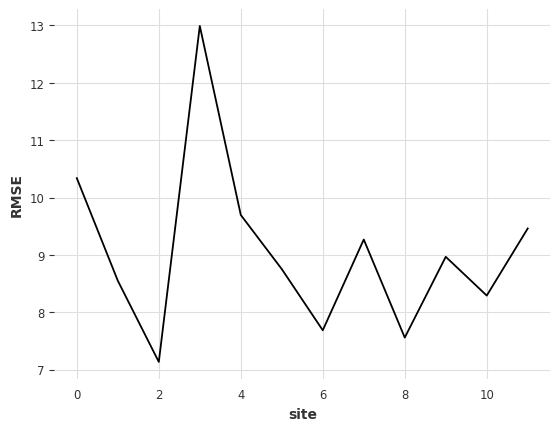

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(backtest_output)

ax.set(xlabel='site', ylabel='RMSE')
plt.show()

In [20]:
for i in range(len(backtest_output)):
  print(backtest_output[i])

10.337477818244096
8.549390782645913
7.133398226683662
12.992330297671309
9.69584631738286
8.751870187824938
7.685069156999425
9.267833068535841
7.557961483101889
8.966235590912222
8.29051015321665
9.460422613548017


In [5]:

tft_test = []
test_length = 36

for ts in target_series:
    tft_test.append(ts.slice(split_point_2, len(ts) - test_length))

predict_output = tftmodel.predict(test_length,
                               series=tft_test,
                               past_covariates=cov_series,
                               future_covariates=cov_series,
                               num_samples=200)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

35028
35027


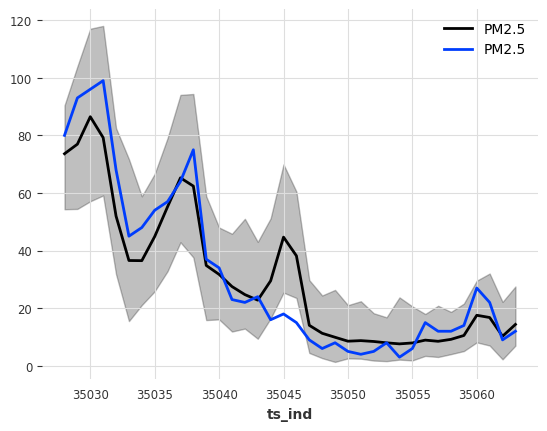

In [14]:
predict_output[5].plot()
test_target_series[5][-test_length:].plot()

print(predict_output[5].start_time())
print(tft_test[5].end_time())

In [9]:
print(predict_output[0].start_time())
print(test_target_series[0][-test_length:].start_time())

print(predict_output[0].end_time())
print(test_target_series[0][-test_length:].end_time())

35028
35028
35063
35063


In [11]:
from darts.metrics.metrics import rmse, mape

for i in range(0,len(predict_output)):
    print("rmse {} mape {}".format(rmse(predict_output[i], test_target_series[i][-test_length:]),
                                   mape(predict_output[i], test_target_series[i][-test_length:])
                                   ))

rmse 16.563114022848488 mape 34.84132467818194
rmse 8.459412542924552 mape 28.34553267847658
rmse 8.998536561527443 mape 27.968881049712202
rmse 5.764805877050353 mape 21.916739344432663
rmse 7.591531859809695 mape 23.12175288848602
rmse 9.546608301247554 mape 28.31816834861034
rmse 10.63794985311721 mape 23.830191695277126
rmse 12.465447973670377 mape 31.976439599126017
rmse 6.628400368167575 mape 14.848122262477364
rmse 6.539841859039519 mape 23.718022735758204
rmse 15.312162795279333 mape 38.7421642163167
rmse 8.902353348599558 mape 28.575083872811135


In [ ]:
backtest_output = tcn.backtest(series = test_target_series,
                                      past_covariates=cov_series,
                                      future_covariates=test_cov_series,
                                      retrain=False,
                                      metric=rmse,
                                      start=0.9,
                                      num_samples=200)

In [ ]:
from darts.metrics.metrics import rmse, mape

tft_hf = tftmodel.historical_forecasts(
    series = test_target_series,
    past_covariates=cov_series,
    future_covariates=test_cov_series,
    retrain=False,
    num_samples=200,
    start=0.9
)

<Axes: xlabel='time'>

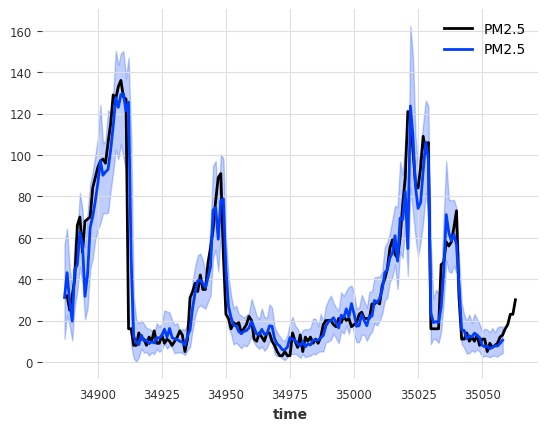

In [ ]:
which_series = 3

test_target_series[which_series][int(len(test_target_series[which_series]) * 0.9):].plot()
tft_hf[which_series].plot()

In [ ]:
from darts.metrics.metrics import rmse, mape

for i in range(0,len(tft_hf)):
    print("rmse {} mape {}".format(rmse(tft_hf[i], test_target_series[i][int(len(test_target_series[i]) * 0.9):]),
                                   mape(tft_hf[i], test_target_series[i][int(len(test_target_series[i]) * 0.9):])))

rmse 11.031698133408181 mape 22.200657602981707
rmse 10.345103168920526 mape 26.017320829799935
rmse 7.101456457259112 mape 19.378444233135724
rmse 12.773789270275843 mape 22.637162814005414
rmse 8.633388104920277 mape 25.11254024253018
rmse 12.503311270666181 mape 19.521091288022088
rmse 9.45912052163355 mape 21.504725948630725
rmse 12.112605776182411 mape 24.67155042057477
rmse 7.146249536616459 mape 16.0306212383351
rmse 9.345807547462956 mape 21.395506163787516
rmse 12.009364075176611 mape 21.837469314951623
rmse 12.16423781331902 mape 22.991713437551613


In [ ]:
from darts.models import TCNModel

tcn_model = TCNModel.load("/content/drive/MyDrive/tcn_model/11_11")

In [ ]:
tcn_test = []

for ts in target_series:
    tcn_test.append(ts.slice(split_point_2, len(ts) - test_length))

tcn_predict_output = tcn_model.predict(test_length,
                               series=tcn_test,
                               past_covariates=cov_series,
                               num_samples=200)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from darts.metrics.metrics import rmse, mape

for i in range(0,len(tcn_predict_output)):
    print("rmse {} mape {}".format(rmse(tcn_predict_output[i], test_target_series[i][-test_length:]), mape(tcn_predict_output[i], test_target_series[i][-test_length:])))

rmse 79.50846304053368 mape 71.53672745384017
rmse 59.127782494514626 mape 66.37049343240706
rmse 59.69130526116846 mape 69.49335308159617
rmse 72.25156436524615 mape 68.88185153755192
rmse 75.90314564801429 mape 69.64639715704054
rmse 65.98068130643286 mape 65.50548146833694
rmse 75.50720967569626 mape 73.23311227710575
rmse 72.89582798664452 mape 68.61893409135646
rmse 69.10719449763646 mape 66.21878658618925
rmse 76.75320337386405 mape 69.9847246639586
rmse 84.85597524220836 mape 74.99291042674739
rmse 73.50939077192209 mape 69.46280362927997


In [ ]:
tcn_backtest = tcn_model.backtest(series = test_target_series,
                                  past_covariates=cov_series,
                                  retrain=False,
                                  metric=rmse,
                                  start=0.9,
                                  num_samples=200)

Streaming output truncated to the last 5000 lines.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU availa

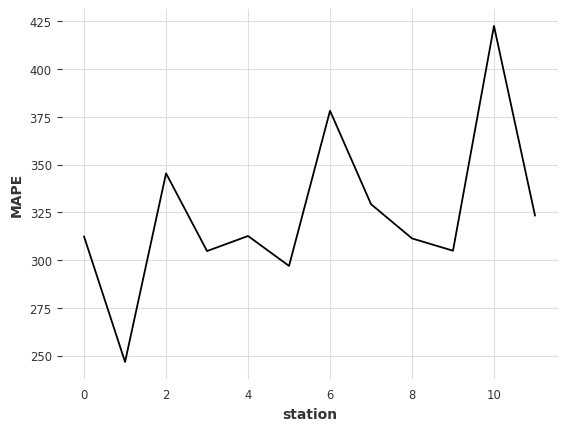

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(tcn_backtest)

ax.set(xlabel='station', ylabel='RMSE')
plt.show()

In [ ]:
from darts.models import NaiveDrift

nd_model = NaiveDrift()
nd_model.fit(past_target_series[0])

In [ ]:
pred = nd_model.backtest(test_target_series, start=0.9, metric=rmse)

In [ ]:
print(pred)

[7.480561164518679, 7.362171196580614, 5.952883799252584, 6.578277812764212, 7.247397250267976, 5.9818597497473975, 5.809237642992871, 11.604786894291086, 7.786645293620601, 7.6656459562848305, 6.523146472156968, 9.80534046028262]


In [ ]:
for i in range(0,len(tft_hf)):
    print("rmse TFT {} ND {}".format(backtest_output[i], pred[i]))

rmse TFT 6.1138579570389044 ND 7.480561164518679
rmse TFT 6.3005642052720185 ND 7.362171196580614
rmse TFT 4.373605114635865 ND 5.952883799252584
rmse TFT 6.371206849139932 ND 6.578277812764212
rmse TFT 6.03744242694609 ND 7.247397250267976
rmse TFT 5.433870995856105 ND 5.9818597497473975
rmse TFT 5.583318052474811 ND 5.809237642992871
rmse TFT 6.990750392387909 ND 11.604786894291086
rmse TFT 4.510602934697088 ND 7.786645293620601
rmse TFT 5.804867907171186 ND 7.6656459562848305
rmse TFT 6.188899888545515 ND 6.523146472156968
rmse TFT 6.821783255148998 ND 9.80534046028262


In [ ]:
#tcn_backtest

for i in range(0,len(tcn_backtest)):
    print("rmse TCN {} ND {}".format(tcn_backtest[i], pred[i]))

rmse TCN 43.9189821839303 ND 7.480561164518679
rmse TCN 33.38532809737654 ND 7.362171196580614
rmse TCN 35.76008341815367 ND 5.952883799252584
rmse TCN 40.76198805665339 ND 6.578277812764212
rmse TCN 40.35901519895231 ND 7.247397250267976
rmse TCN 36.12480625463895 ND 5.9818597497473975
rmse TCN 40.08357859212686 ND 5.809237642992871
rmse TCN 41.997727162436426 ND 11.604786894291086
rmse TCN 40.5507037235339 ND 7.786645293620601
rmse TCN 42.064123448527184 ND 7.6656459562848305
rmse TCN 42.632454553574156 ND 6.523146472156968
rmse TCN 43.02543466709438 ND 9.80534046028262
